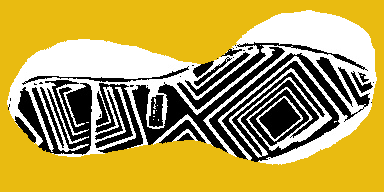

In [14]:
#@title ##← Click on the circled arrow and wait for up to 2 minute

import sys
# !{sys.executable} -m pip install torch==1.11.0+cu102  --extra-index-url https://download.pytorch.org/whl/cu102



import torch
import torch.nn as nn
import torch.nn.functional as F

import requests
import numpy as np
import os
import urllib.request
import numpy as np

from IPython.display import display, Markdown, HTML, clear_output
import ipywidgets as widgets
import io
from PIL import Image
import zipfile


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channel=2, zero_init_residual=False, final_pool=False):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.final_pool = final_pool

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        if self.final_pool:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves
        # like an identity. This improves the model by 0.2~0.3% according to:
        # https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride, maxpool=False, maxpool2=False):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
            if maxpool2:
                layers.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        if maxpool:
            layers.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        return nn.Sequential(*layers)

    def forward(self, x, mask=None):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out1 = self.layer4(out)
        if self.final_pool:
            if mask is not None:
                # mask penultimate features out1
                # in other words, average over only the relavant portions of the image
                out1[~mask.expand_as(out1)] = 0

            out = self.avgpool(out1)
            out = torch.flatten(out, 1)
            return out
        return out1

    
class MatchingModel(nn.Module):
    """backbone + projection head"""
    def __init__(self, feat_dim=128, in_channel=2, dim_in=2048):
        super(MatchingModel, self).__init__()
        self.encoder = ResNet(Bottleneck, [3, 4, 6, 3], in_channel=in_channel, final_pool=False)
        self.head = nn.Sequential(
                nn.Conv2d(dim_in, dim_in, 1),
                nn.ReLU(inplace=True),
                nn.Conv2d(dim_in, feat_dim, 1)
            )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x, spatial_feat=False, mask=None):
        feat = self.encoder(x, mask=mask)
        if mask is not None:
            embedded = self.head(feat)
            embedded[~mask.expand_as(embedded)] = 0
        else:
            embedded = self.head(feat)

        return embedded if spatial_feat else self.vectorize(embedded) # , _
    def vectorize(self, x):
        return F.normalize(torch.flatten(self.avgpool(x), 1), dim=1)

    
    

def download(id, destination):
    if not os.path.exists(destination):
        URL = "https://docs.google.com/uc?export=download"

        session = requests.Session()

        response = session.get(URL, params = { 'id' : id }, stream = True)
        token = get_confirm_token(response)

        if token:
            params = { 'id' : id, 'confirm' : token }
            response = session.get(URL, params = params, stream = True)

        save_response_content(response, destination)  

def get_confirm_token(response):
    if 'too large for Google to scan for viruses. Would you still like to download this file?' in response.text:
        return True

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
def get_html(img, match_names, match_values, height=200):
    html = "<div style='margin-top: 20px; display: flex; flex-wrap: wrap; justify-content: space-evenly'>"
    for name, value in zip(match_names, match_values):
        path = os.path.join(database_name, 'image', name)
        name = name + '_similarity_' + str(value)
        html2 = f"<img title='{name}' style='height: {height}px; margin-bottom: 10px' src='{path}'>"
        html = html + html2
    html += "</div>"
    return html


def load_model(weights):
    net = MatchingModel().to(device)
    file_id = '1UykBQexdmq8R4H51SImFMpZLvBZKoY7i'
    download(file_id, weights)
    net.load_state_dict(torch.load(weights, map_location=device))
    return net


def image_search(query_image, n_results=24):
    img = np.array(query_image)
    if len(img.shape) == 3:
        img = np.mean(img, axis=2)
    img = torch.tensor(img/255.0).to(device).unsqueeze(0).unsqueeze(0)
    zeros = torch.zeros(img.shape).to(device)
    query = torch.cat((img, zeros), dim=1).float()
    
    net.eval()
    with torch.no_grad():
        query_features = net(query)
        query_dot_dataset = torch.matmul(query_features, database_features.T)
        values, indices = torch.sort(query_dot_dataset, dim=1, descending=True)
        indices = indices.squeeze().detach().cpu().numpy()
        match_names = database_names[indices][:n_results]
        values = values.squeeze().detach().cpu().numpy()
        match_values = values[:n_results]
    return match_names, match_values
    

def display_results(query_image, match_names, match_values):
    clear_output()
    display(search_widget)
    display(query_image)
    for match_name in match_names:
        path = os.path.join(database_name, 'image', match_name)
        img1 = open(path, 'rb').read()
        wi1 = widgets.Image(value=img1)
        path = os.path.join(database_name, 'print', match_name)
        img2 = open(path, 'rb').read()
        wi2 = widgets.Image(value=img2)
        button = widgets.Button(description="More like this")
        button.filename = match_name
        button.on_click(on_show_more_button_clicked)
        box_layout = widgets.Layout(display='flex',
            flex_flow='row',
            align_items='center')
        display(widgets.HBox(children=[wi1, wi2, button], layout=box_layout))
    

def outline_image(image, outline):
    image = np.array(image)
    if len(image.shape) == 2:
        image = image[:, :, np.newaxis].repeat(3, axis=2)    
    if np.max(image) == 1:
        image = image *255
    outline_mask = np.array(outline)[:,:, 3] != 0
    outline_color = np.array(outline)[0,0,0:3]
#     image[outline_mask] = (image[outline_mask] + outline_color)/2
    image[outline_mask] = outline_color
    return Image.fromarray(image)
    

def on_button_clicked(b):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
        query_image = img.resize((384, 192))
        match_names, match_values = image_search(query_image, n_results)
        outlined_query = outline_image(query_image, outline)
        display_results(outlined_query, match_names, match_values)
        
        

def on_show_more_button_clicked(b):
    path = os.path.join(database_name, 'print', b.filename)
    query = Image.open(path)
    match_names, match_values = image_search(query, n_results)
    outlined_query = outline_image(query, outline)
    display_results(outlined_query, match_names, match_values)
    

device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')  
    
print('==> Loading model')
net = load_model('model.pth')

print('==> Loading database features')
database_feat_name = 'database_features.pt'
file_id = '1qC341oZLESYO-hc3H2efhz5w7YDqag6s'
download(file_id, database_feat_name)
database_features = torch.load(database_feat_name, map_location=device).to(device)

database_names = 'database_names.npy'
file_id = '1h57KcyaO-ZynI4iS0j0_uHfFMXW44RWy'
download(file_id, database_names)
database_names = np.load(database_names)

print('==> Loading database images')
database_name = 'database'
file_id = '1VnL5WU0kVW8NIIajKFHuSKcp1SG9KHa3'
download(file_id, database_name + '.zip')
if not os.path.exists(database_name):
    with zipfile.ZipFile(database_name + '.zip', 'r') as zip_ref:
        zip_ref.extractall()
        
# download outline
outline_name = 'outline.png'
file_id = '16q9Uj9xR0_R4i1rB9kWXiNuR62GplNRm'
download(file_id, outline_name)
outline = Image.open(outline_name)
# outline.putalpha(0)
    
        
clear_output()
button = widgets.Button(description="Search")
# output = widgets.Output()
uploader = widgets.FileUpload(multiple=False)
search_widget = widgets.HBox([uploader, button], layout=widgets.Layout(justify_content='center'))
display(search_widget)
button.on_click(on_button_clicked)

n_results = 10